In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("error", category=RuntimeWarning)

from aeons.lm_partial import analytic_lm_params, X_end_formula
from aeons.covariance import X_mu, X_Sigmainv, logX_mu, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG

#### Functions

In [14]:
from scipy.special import gammainc, gamma, logsumexp, loggamma, gammaincinv
def logXf_formula_gaussian(theta, epsilon=1e-3):
    _, d, sigma = theta
    return d/2*np.log(2) + d * np.log(sigma) + loggamma(1 + d/2) + np.log(epsilon)

def end_iteration(samples, N, start=0.5, epsilon=1e-3):
    iterations = np.linspace(len(samples) * start, len(samples), N, endpoint=False).astype(int)
    for ndead in iterations:
        ndead = int(ndead)
        points = points_at_iteration(samples, ndead)
        weights = points.get_weights()
        if weights[ndead:].sum()/weights.sum() < epsilon:
            return ndead
        
def minimise_bandwidth(logL, X_mean, ndead, alphas, x0, warnings=False, give_alpha=False):
    theta_best = analytic_lm_params(logL[ndead:], X_mean[ndead:], x0)
    alpha_best = 0
    logZi = -np.inf
    for alpha in alphas:
        startf = int(ndead * (1 - alpha))
        logLf = logL[startf:]
        X_meanf = X_mean[startf:]
        ls = LS(logL, full, X_mean)
        theta = analytic_lm_params(logLf, X_meanf, x0)
        try:
            logZf = ls.logZ(theta)# + startf * np.log(startf)
        except RuntimeWarning:
            if warnings:
                print(np.round(theta, 2), 'warning', alpha)
            continue
        if logZf > logZi:
            theta_best = theta
            alpha_best = alpha
    if give_alpha:
        print(alpha_best)
    return theta_best

def logXf_formula(theta, logZdead, Xi, epsilon=1e-3):
    logLmax, d, sigma = theta
    loglive = np.log( gamma(d/2) * gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )
    logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)
    logend = logsumexp([loglive, logdead]) + np.log(epsilon)
    xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))
    return d/2 * np.log(2*sigma**2 * xf_reg)

#### Set up sample

In [3]:
from aeons.toy_samples import correlated_gaussian_samples

nlive = 500
d = 10
sigma = 0.1
samples = correlated_gaussian_samples(nlive, d, sigma)

In [4]:
kf = end_iteration(samples, N=40, start=0.8)
logXf_true = samples.logX()[kf]
logXf_true

-22.327410407697776

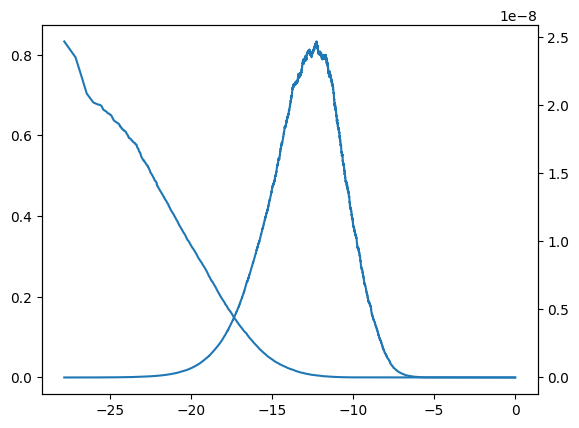

In [5]:
logL = samples.logL
L = np.exp(logL)
logX = samples.logX()
X = np.exp(logX)
fig, ax1 = plt.subplots()
ax2 = plt.twinx(ax1)
ax1.plot(logX, L)
ax2.plot(logX, L*X)

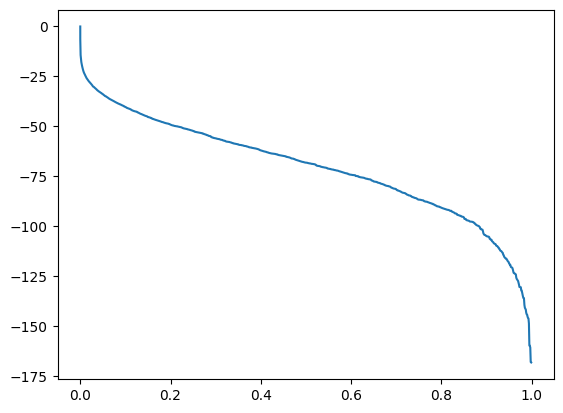

In [6]:
plt.plot(X, logL)

#### Single iteration

In [12]:
ndead = 5000
points = points_at_iteration(samples, ndead)
nk = np.array(points.nlive)
logL = np.array(points.logL)
X_mean = X_mu(nk)

In [13]:
alphas = np.linspace(0, 1, 5)
minimise_bandwidth(logL, X_mean, ndead, alphas, 1)

/home/zixiao/Documents/III/project/aeons/aeons/likelihoods.py:109: RuntimeWarning: invalid value encountered in power
  return (2*sigma**2 * (logLmax - logL))**(d/2)
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


[-3.551745656763128, 7.863958468400834, 0.08677157958810747]

In [14]:
analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)

[-0.7015609768804705, 8.985826602491903, 0.0857243099250512]

#### Full run - no bandwidth

In [15]:
N = 50
iterations = np.linspace(0, len(samples), N, endpoint=False).astype(int)
logXfs = np.zeros(N)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    X_mean = X_mu(nk)
    theta_l = analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)
    logXfs[i] = logXf_formula_gaussian(theta_l)

(0.0, 15000.0)

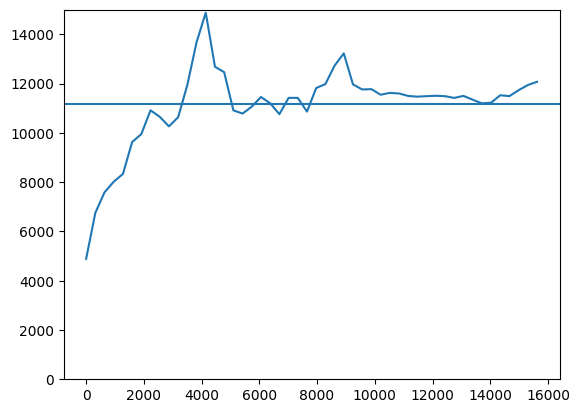

In [16]:
plt.plot(iterations, logXfs * (-nlive))
plt.axhline(y=logXf_true * (-nlive))
plt.ylim(0, 15000)

#### Full run - bandwidth

In [7]:
N = 20
iterations = np.linspace(0, len(samples), N, endpoint=False).astype(int)
logXfs = np.zeros(N)
alphas = np.linspace(0, 1, 10)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    X_mean = X_mu(nk)
    theta_best = minimise_bandwidth(logL, X_mean, ndead, alphas, 1)
    logXfs[i] = logXf_formula_gaussian(theta_best)

(0.0, 12000.0)

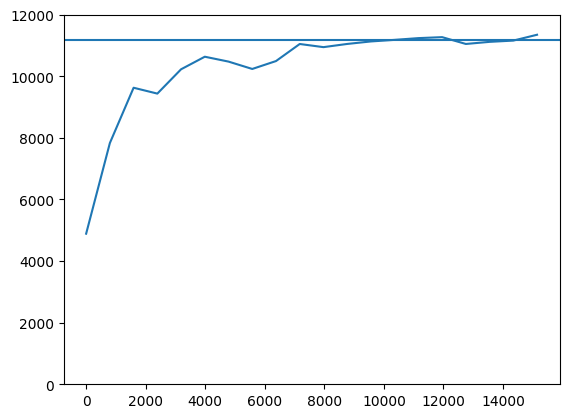

In [8]:
plt.plot(iterations, logXfs * (-nlive))
plt.axhline(y=logXf_true * (-nlive))
plt.ylim(0, 12000)

#### Full run - error, no bandwidth

In [29]:
N = 20
iterations = np.linspace(100, len(samples), N, endpoint=False).astype(int)
logXfs = np.zeros(N)
logXfs_std = np.zeros(N)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    logXf_i = []
    for _ in range(10):
        X = generate_Xs(nk)
        theta_l = analytic_lm_params(logL[ndead:], X[ndead:], 1)
        try:
            logZdead = logsumexp(points.logw()[:ndead])
            logXf_i.append(logXf_formula(theta_l, logZdead, X_mean[ndead]))
        except:
            print(theta_l, 'warning')
        # logXf_i.append(logXf_formula_gaussian(theta_l))
    logXfs[i] = np.mean(logXf_i)
    logXfs_std[i] = np.std(logXf_i)

(0.0, 15000.0)

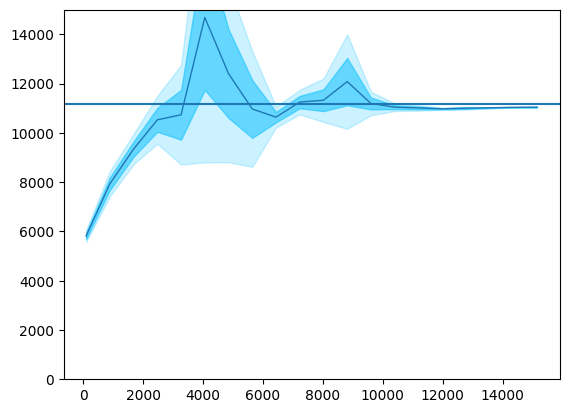

In [30]:
plt.plot(iterations, logXfs * (-nlive), lw=1)
plt.fill_between(iterations, (logXfs - logXfs_std) * (-nlive), (logXfs + logXfs_std) * (-nlive), alpha=0.5, color='deepskyblue')
plt.fill_between(iterations, (logXfs - 2*logXfs_std) * (-nlive), (logXfs + 2*logXfs_std) * (-nlive), alpha=0.2, color='deepskyblue')
plt.axhline(logXf_true * (-nlive))
plt.ylim(0, 15000)

#### Full run - error, bandwidth

In [9]:
N = 20
iterations = np.linspace(0, len(samples), N, endpoint=False).astype(int)
logXfs = np.zeros(N)
logXfs_std = np.zeros(N)
alphas = np.linspace(0, 1, 5)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    logXf_i = []
    for _ in range(10):
        X = generate_Xs(nk)
        theta_best = minimise_bandwidth(logL, X, ndead, alphas, 1)
        logXf_i.append(logXf_formula_gaussian(theta_best))
    logXfs[i] = np.mean(logXf_i)
    logXfs_std[i] = np.std(logXf_i)

In [35]:
N = 10
iterations = np.linspace(100, len(samples), N, endpoint=False).astype(int)
logXfs = np.zeros(N)
logXfs_std = np.zeros(N)
alphas = np.linspace(0, 1, 10)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    logXf_i = []
    for _ in range(10):
        X = generate_Xs(nk)
        # theta_best = analytic_lm_params(logL[ndead:], X[ndead:], 1)
        theta_best = minimise_bandwidth(logL, X, ndead, [0.4], 1, give_alpha=1)
        try:
            logZdead = logsumexp(points.logw()[:ndead])
            logXf_i.append(logXf_formula(theta_best, logZdead, X_mean[ndead]))
        except:
            print(theta_best, 'warning')
            continue
    logXfs[i] = np.mean(logXf_i)
    logXfs_std[i] = np.std(logXf_i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.4
0
0
0
0
0
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4


(0.0, 13000.0)

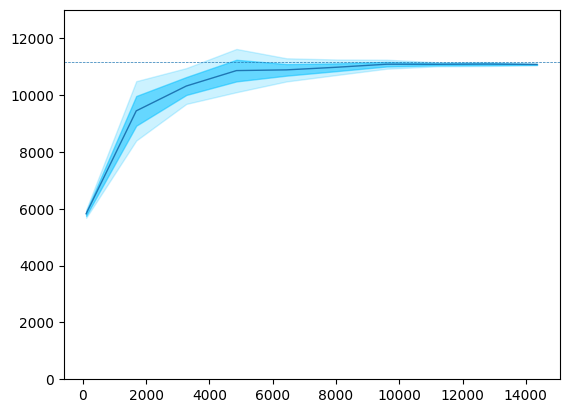

In [36]:
plt.plot(iterations, logXfs * (-nlive), lw=1)
plt.axhline(logXf_true * (-nlive), lw=.5, ls='--')
plt.fill_between(iterations, (logXfs - logXfs_std) * (-nlive), (logXfs + logXfs_std) * (-nlive), alpha=0.5, color='deepskyblue')
plt.fill_between(iterations, (logXfs - 2*logXfs_std) * (-nlive), (logXfs + 2*logXfs_std) * (-nlive), alpha=0.2, color='deepskyblue')
plt.ylim(0, 13000)